In [18]:
# 1. Imports
from src.load_data import load_interactions, filter_min_activity 
from src.split import temporal_train_val_split, get_val_ground_truth 
from src.metrics import recall_at_k, precision_at_k 
from src.baselines import PopularityRecommender, ItemKNNRecommender
from src.config import DATA_DIR
from src.models.mf import MFRecommender
import pandas as pd

In [2]:
# 2. Load, filter, set number of items for evaluation
df = load_interactions(DATA_DIR, nrows = 100_000) 
df = filter_min_activity(df, min_user_interactions=3, min_item_interactions=3)
ks = [5,10,20]

In [3]:
# 3. Train/validation split train_df, 
train_df, val_df = temporal_train_val_split(df, val_fraction=0.2) 
val_truth = get_val_ground_truth(val_df)

In [4]:
# 4. Fit baselines 
pop = PopularityRecommender(top_k=1000).fit(train_df) 
knn = ItemKNNRecommender(n_neighbors=50).fit(train_df)
print("MFRecommender in globals()? ->", "MFRecommender" in globals())
mf = MFRecommender(
    factors = 64,
    regularization = 0.01,
    iterations = 20).fit(train_df)

MFRecommender in globals()? -> True


/opt/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
# 5. Generate recommendations for test users 
val_users = list(val_truth.keys())
pop_preds = { k: [pop.recommend(u, k=k) for u in val_users] 
             for k in ks }
knn_preds = { k: [knn.recommend(u, k=k) for u in val_users] 
             for k in ks }
y_true = [val_truth[u] for u in val_users]
mf_preds = { k: [mf.recommend(u, k = k) for u in val_users]
            for k in ks }


In [23]:
# 6. Evaluate
rows = []
for k in ks:
    for name, preds in [("Popularity", pop_preds), ("ItemKNN", knn_preds), ("MF", mf_preds)]:
        r = recall_at_k(y_true, preds[k], k=k)
        p = precision_at_k(y_true, preds[k], k=k)

        rows.append({
            "model": name,
            "k": k, 
            "recall": r,
            "precision": p,
        })
all_results = pd.DataFrame(rows)

<Axes: xlabel='k', ylabel='recall'>

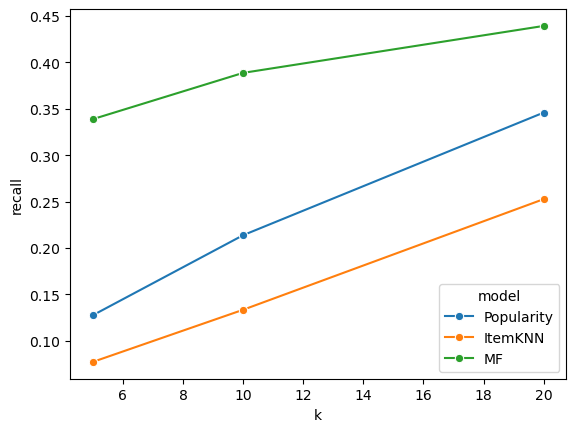

In [24]:
#7. Visualization
import seaborn as sns
sns.lineplot(
    data = all_results,
    x = "k",
    y = "recall", 
    hue = "model", 
    marker = "o"
)